In [2]:
%%capture output
%pip install numpy
%pip install matplotlib
%pip install gpflow

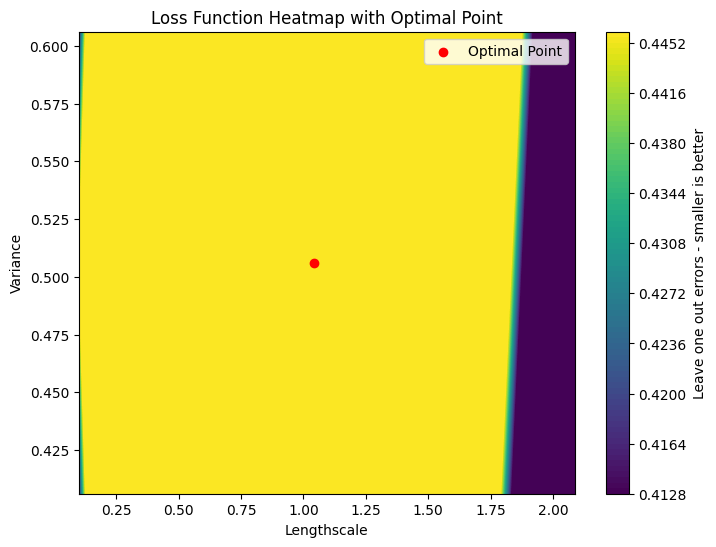

In [21]:
import numpy as np
import gpflow
from gpflow.kernels import Matern52 as mt52
import matplotlib.pyplot as plt

def get_dataset(n : int = 5):
    dataset = [10,1] * np.random.rand(n,2)
    # {x,y}
    return np.array(dataset)

def get_sin_abs_dataset(n : int = 5):
    x = np.random.rand(n,1)*2*np.pi
    y = np.abs(np.sin(x))
    return np.hstack((x,y))

def plot_gp(ax, X,Y , model):
    Xplot = np.linspace(0,10, 100).reshape(-1,1)
    f_mean, f_var = model.predict_f(Xplot, full_cov=False)
    y_mean, y_var = model.predict_y(Xplot)
    f_lower = f_mean - 1.96 * np.sqrt(f_var)
    f_upper = f_mean + 1.96 * np.sqrt(f_var)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    ax.plot(X, Y, "kx", mew=2, label="Input data")
    ax.plot(Xplot, f_mean, "-", color="C0", label="Mean")

    ax.fill_between(
        Xplot[:, 0], f_lower[:, 0], f_upper[:, 0], 
        color="C0", alpha=0.1, label="f 95% CI")
    
    ax.fill_between(
        Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], 
        color="C1", alpha=0.1, label="y 95% CI")
    
    ax.legend()

def loo_cross_validation(model, X, Y):
    n = X.shape[0]
    loo_errors = []
    for i in range(n):
        X_train = np.delete(X, i, axis=0)
        Y_train = np.delete(Y, i, axis=0)
        X_test = X[i:i+1]
        Y_test = Y[i:i+1]

        loo_model = gpflow.models.GPR((X_train, Y_train), kernel=model.kernel, mean_function=model.mean_function)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(loo_model.training_loss, loo_model.trainable_variables)

        Y_pred, _ = loo_model.predict_f(X_test)
        loo_errors.append(np.abs(Y_pred - Y_test).item())

    return np.mean(loo_errors)

def plot_performance():
    dataset = get_sin_abs_dataset(5)
    X, Y = dataset[:, 0:1], dataset[:, 1:2]

    # Initialize model with default kernel
    initial_kernel = mt52(variance=1.0, lengthscales=1.0)
    model = gpflow.models.GPR((X, Y), kernel=initial_kernel)

    # Optimize the hyperparameters
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    optimal_lengthscale = model.kernel.lengthscales.numpy()
    optimal_variance = model.kernel.variance.numpy()

    # Create a refined search grid around the optimal values
    lengthscale = np.linspace(0, optimal_lengthscale *2, 50)
    variance = np.linspace(optimal_variance-0.1, optimal_variance +0.1, 3)
    lengthscale = np.clip(lengthscale, 0.1, None)  # Avoid invalid values
    variance = np.clip(variance, 0.1, None)

    X1, X2 = np.meshgrid(lengthscale, variance)

    loo_errors = np.zeros_like(X1)
    for idx, (l, c) in enumerate(zip(X1.ravel(), X2.ravel())):
        kernel = mt52(variance=c, lengthscales=l)
        model = gpflow.models.GPR((X, Y), kernel=kernel)
        loo_errors.ravel()[idx] = loo_cross_validation(model, X, Y)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X1, X2, loo_errors, levels=100, cmap="viridis")
    plt.colorbar(contour, label="Leave one out errors - smaller is better")
    plt.xlabel("Lengthscale")
    plt.ylabel("Variance")
    plt.title("Loss Function Heatmap with Optimal Point")

    # Mark the optimal point
    plt.scatter(optimal_lengthscale, optimal_variance, color="red", label="Optimal Point", zorder=5)
    plt.legend()
    plt.show()


def main_1():
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for _, ax in enumerate(axes):
        dataset = get_dataset()
        X, Y = dataset[:, 0].reshape(-1,1) ,  dataset[:, 1].reshape(-1,1)
        #print(X, Y)
        gp = gpflow.models.GPR((X, Y), kernel=mt52())
        opt = gpflow.optimizers.Scipy()
        opt.minimize(gp.training_loss, gp.trainable_variables)
        plot_gp(ax, X, Y, gp)

    plt.tight_layout()
    plt.show()

def main_2():
    plot_performance()
    return


main_2()

    
